In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import plotly as py
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

**EDA**

In [2]:
cs_df = pd.read_excel(io=r'/content/Online Retail.xlsx')

In [3]:
cs_df.shape

(541909, 8)

In [4]:
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# how many different custromers?
cs_df.CustomerID.unique().shape

(4373,)

In [7]:
# how many unique items?
cs_df.StockCode.unique().shape

(4070,)

In [8]:
cs_df.Description.unique().shape

(4224,)

In [9]:
# interfering description for items?
cat_des_df = cs_df.groupby(["StockCode","Description"]).count().reset_index()
cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts() > 1].reset_index().head()

,index,StockCode
0,20713,8
1,23084,7
2,21830,6
3,85175,6
4,23343,5


In [10]:
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
                            .reset_index()['index'][6]]['Description'].unique()

array(['SET/3 ROSE CANDLE IN JEWELLED BOX', 'wet pallet', 'damages',
       '???missing', 'AMAZON'], dtype=object)

In [11]:
cs_df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [12]:
cs_df.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

**Data cleaning**

In [13]:
# for UK custromers only
cs_df = cs_df[cs_df.Country == 'United Kingdom']
# Separate attribute for total amount
cs_df['amount'] = cs_df.Quantity * cs_df.UnitPrice
# Remove negative or return transactions
cs_df = cs_df[~(cs_df.amount<0)]
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [14]:
cs_df = cs_df[~(cs_df.CustomerID.isnull())]
cs_df.shape

(354345, 9)

In [15]:
refrence_date = cs_df.InvoiceDate.max()
refrence_date = refrence_date + datetime.timedelta(days = 1)
refrence_date

Timestamp('2011-12-10 12:49:00')

In [16]:
# recency value
cs_df['days_since_last_purchase'] = refrence_date - cs_df.InvoiceDate
cs_df['days_since_last_purchase_num'] = cs_df['days_since_last_purchase'].astype('timedelta64[D]')

In [17]:
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,days_since_last_purchase,days_since_last_purchase_num
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,374 days 04:23:00,374.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:23:00,374.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,374 days 04:23:00,374.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:23:00,374.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:23:00,374.0


In [18]:
customer_history_df = cs_df.groupby(["CustomerID"])[['days_since_last_purchase_num']].min().reset_index()

In [19]:
customer_history_df.rename(columns={'days_since_last_purchase_num':'recency'}, inplace=True)

In [20]:
customer_history_df.head()

,CustomerID,recency
0,12346.0,326.0
1,12747.0,2.0
2,12748.0,1.0
3,12749.0,4.0
4,12820.0,3.0


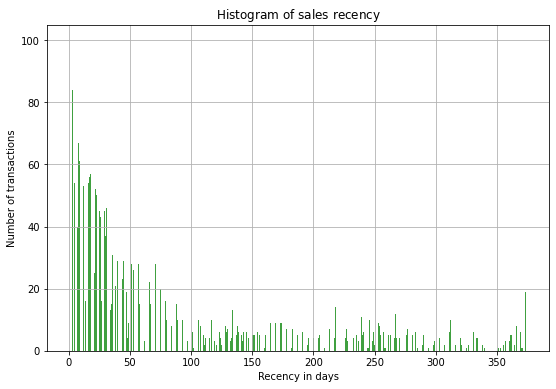

In [21]:
# distribution of customer recency
x = customer_history_df.recency
mu = np.mean(customer_history_df.recency)
sigma = math.sqrt(np.var(customer_history_df.recency))
plt.figure(figsize=(9, 6))
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')
plt.grid(True)

In [22]:
# monetary value
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()

In [23]:
customer_monetary_val.head()

,CustomerID,amount
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33719.73
3,12749.0,4090.88
4,12820.0,942.34


In [24]:
customer_history_df = customer_history_df.merge(customer_monetary_val, how='outer')
customer_history_df.amount = customer_history_df.amount + 0.001

In [25]:
customer_history_df.head()

,CustomerID,recency,amount
0,12346.0,326.0,77183.601
1,12747.0,2.0,4196.011
2,12748.0,1.0,33719.731
3,12749.0,4.0,4090.881
4,12820.0,3.0,942.341


In [26]:
# frequency
customer_freq = cs_df[['CustomerID', 'amount']].groupby("CustomerID").count().reset_index()
customer_freq.rename(columns={'amount':'frequency'}, inplace=True)

In [27]:
customer_history_df = customer_history_df.merge(customer_freq, how='outer')

In [28]:
customer_history_df.head()

,CustomerID,recency,amount,frequency
0,12346.0,326.0,77183.601,1
1,12747.0,2.0,4196.011,103
2,12748.0,1.0,33719.731,4596
3,12749.0,4.0,4090.881,199
4,12820.0,3.0,942.341,59


**Data preprocessing**

In [29]:
# log scaling
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)

In [30]:
# standart scaling
feature_vector = ['amount_log', 'recency_log','frequency_log']
X = customer_history_df[feature_vector].values
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

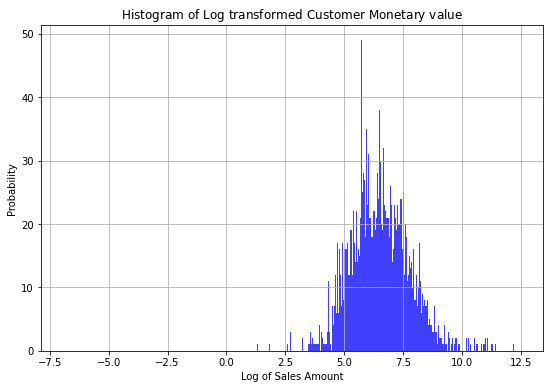

In [31]:
x = customer_history_df.amount_log
plt.figure(figsize=(9, 6))
n, bins, patches = plt.hist(x, 1000, facecolor='blue', alpha=0.75)
plt.xlabel('Log of Sales Amount')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Log\ transformed\ Customer\ Monetary\ value}\ $')
plt.grid(True)

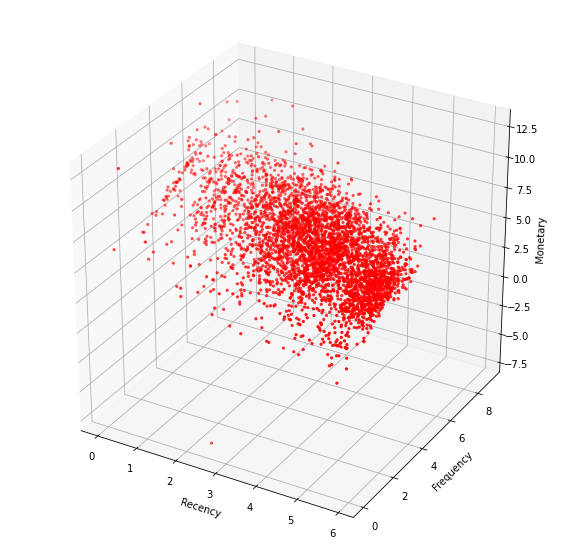

In [32]:
# 3d scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5, c='r')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

**Model**

In [33]:
# cluster analysis
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
cluster_centers = dict()

for n_clusters in range(3, 6, 2):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}})
    print('=' * 50)
    print("for {} number of clusters".format(n_clusters))
    cent_transformed = scaler.inverse_transform(cluster_centers[n_clusters]['cluster_center']) 
    print(pd.DataFrame(np.exp(cent_transformed), columns=feature_vector)) 
    print("Silhouette score for cluster {} is {}".format(n_clusters, cluster_centers[n_clusters]['silhouette_score']))
    print('=' * 50)

for 3 number of clusters
     amount_log   recency_log  frequency_log
0  3.464693e+06  10586.080988    8109.845433
1  6.444703e+05  45466.559613     910.918045
2  1.610609e+07    667.829810   35274.102846
Silhouette score for cluster 3 is 0.3033291137814411
for 5 number of clusters
     amount_log   recency_log  frequency_log
0  2.230630e+07    418.589110   47201.824919
1  3.786077e+05  48769.141560     357.922021
2  7.798905e+06   9181.429641   18733.558733
3  1.474204e+06   2216.636204    3157.711108
4  1.522477e+06  53409.948623    3241.337594
Silhouette score for cluster 5 is 0.28238738536039376


In [34]:
# 
labels = cluster_centers[5]['labels']
customer_history_df['num_cluster5_labels'] = labels
labels = cluster_centers[3]['labels']
customer_history_df['num_cluster3_labels'] = labels

In [35]:
customer_history_df.head()

,CustomerID,recency,amount,frequency,recency_log,frequency_log,amount_log,num_cluster5_labels,num_cluster3_labels
0,12346.0,326.0,77183.601,1,5.786897,0.000000,11.253942,4,0
1,12747.0,2.0,4196.011,103,0.693147,4.634729,8.341890,0,2
2,12748.0,1.0,33719.731,4596,0.000000,8.432942,10.425838,0,2
3,12749.0,4.0,4090.881,199,1.386294,5.293305,8.316516,0,2
4,12820.0,3.0,942.341,59,1.098612,4.077537,6.848367,0,2


In [36]:
x_data = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
cutoff_quantile = 80
field_to_plot = 'amount'
# select amount data for each cluster
y0 = customer_history_df[customer_history_df['num_cluster5_labels']==0][field_to_plot].values
y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
y1 = customer_history_df[customer_history_df['num_cluster5_labels']==1][field_to_plot].values
y1 = y1[y1<np.percentile(y1, cutoff_quantile)]
y2 = customer_history_df[customer_history_df['num_cluster5_labels']==2][field_to_plot].values
y2 = y2[y2<np.percentile(y2, cutoff_quantile)]
y3 = customer_history_df[customer_history_df['num_cluster5_labels']==3][field_to_plot].values
y3 = y3[y3<np.percentile(y3, cutoff_quantile)]
y4 = customer_history_df[customer_history_df['num_cluster5_labels']==4][field_to_plot].values
y4 = y4[y4<np.percentile(y4, cutoff_quantile)]
y_data = [y0, y1, y2, y3, y4]

In [42]:
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
          'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']

traces = []
for xd, yd, cls in zip(x_data, y_data, colors):
  traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                       marker=dict(size=2,), line=dict(width=1)))

layout = go.Layout(title='Difference in sales {} from cluster to cluster.'.format(field_to_plot),
                   yaxis=dict(autorange=True, zeroline=True, gridcolor='black', 
                              zerolinecolor='yellow', zerolinewidth=2),
                   margin=dict(l=40, r=30, b=80, t=100), paper_bgcolor='white', plot_bgcolor='white', showlegend=False)

fig = go.Figure(data=traces, layout=layout)
py.offline.iplot(fig)